Dans ce projet, nous allons entrainer un modèle de classification à prédire la catégorie d'un produit donné : soit jouet, instrument de musique, musique digitale, jeu video, produit sportif. Pour cela, on va utiliser le dataset de chez Amazon  

# Charger le dataset 

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving reviews_Video_Games_5.json to reviews_Video_Games_5.json
Saving reviews_Digital_Music_5.json to reviews_Digital_Music_5.json
Saving reviews_Musical_Instruments_5.json to reviews_Musical_Instruments_5.json
Saving reviews_Sports_and_Outdoors_5.json to reviews_Sports_and_Outdoors_5.json
Saving reviews_Toys_and_Games_5.json to reviews_Toys_and_Games_5.json


In [13]:
class Categorie : 
  MUSIC = 'musique_digitale'
  INSTRUMENT = 'instrument_de_music'
  SPORT = 'produit_sportif'
  JOUET = 'jeuet'
  JVIDEO = 'jeu_video'

class Review :
  def __init__(self, categorie, text):
    self.text = text 
    self.categorie = categorie

class ReviewContainer : 
  def __init__(self, reviews):
    self.reviews = reviews

  def get_text(self):
    return [x.text for x in self.reviews]

  def get_categorie(self):
    return [x.categorie for x in self.reviews]

In [14]:
import json
import random


nom_fichier = ['/content/reviews_Digital_Music_5.json', '/content/reviews_Musical_Instruments_5.json', '/content/reviews_Sports_and_Outdoors_5.json', '/content/reviews_Toys_and_Games_5.json', '/content/reviews_Video_Games_5.json']
categorie_fichier = [Categorie.MUSIC, Categorie.INSTRUMENT, Categorie.SPORT, Categorie.JOUET, Categorie.JVIDEO]

reviews = []
for i in range(len(nom_fichier)):
  fichier = nom_fichier[i]
  cat = categorie_fichier[i]
  with open(fichier) as f : 
    for line in f : 
      review = json.loads(line)
      reviews.append(Review(cat, review['reviewText']))


# Preparation de données 

In [15]:
# on divise notre data set en training_data et test_data 
import sklearn.model_selection
training, test = sklearn.model_selection.train_test_split(reviews, test_size = 0.33, random_state = 42)
train_container = ReviewContainer(training)
test_container = ReviewContainer(test)


train_x = train_container.get_text()
train_y = train_container.get_categorie()

test_x = test_container.get_text()
test_y = test_container.get_categorie()

# Bags of words 

In [16]:
#tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_x_vectors = vectorizer.fit_transform(train_x)
test_x_vectors = vectorizer.transform(test_x)

# Entrainement du modèle

In [26]:
# support vector machine
from sklearn.svm import SVC
clf_svm =SVC(C=16, kernel='linear', gamma='auto')
clf_svm.fit(train_x_vectors, train_y)


SVC(C=16, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
print(clf_svm.score(test_x_vectors, test_y))


0.8175757575757576


# Amelioration du modèle

In [28]:
from sklearn.model_selection import GridSearchCV 
parameters = {'kernel':('linear','rbf'), 'C':(1,4,8,16)}
svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x_vectors, train_y)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 4, 8, 16), 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
# meilleurs parametres 
clf.best_params_

{'C': 4, 'kernel': 'rbf'}

In [30]:
clf.best_score_

0.8400000000000001

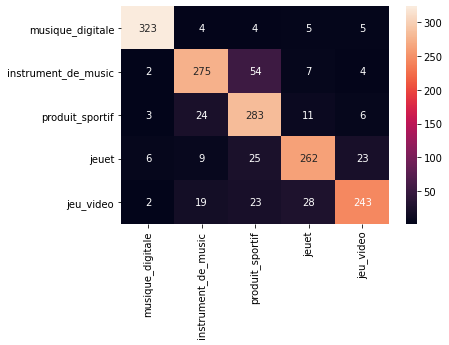

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

y_pred = clf.predict(test_x_vectors)


cm = confusion_matrix(test_y, y_pred, labels=categorie_fichier)
df_cm = pd.DataFrame(cm, index=categorie_fichier, columns=categorie_fichier)

sn.heatmap(df_cm, annot=True, fmt='d')

# Enregistrer le modèle

In [ ]:
import pickle

with open('./models/category_classifier.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
with open('./models/category_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Tester le modèle 

In [52]:
test_set = ['beautiful guitar', "running", 'your voice is overwelming']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['instrument_de_music', 'produit_sportif', 'musique_digitale'],
      dtype='<U19')